In [619]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import signal
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import datetime

In [620]:
df= pd.read_csv(r'C:\Users\paowm\Downloads\Call-Center-Dataset.csv')

In [621]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40517 entries, 0 to 40516
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Call Id              40517 non-null  object 
 1   Date                 40517 non-null  object 
 2   Agent                40517 non-null  object 
 3   Department           40517 non-null  object 
 4   Answered (Y/N)       40517 non-null  object 
 5   Resolved             40517 non-null  object 
 6   Speed of Answer      32759 non-null  float64
 7   AvgTalkDuration      32759 non-null  object 
 8   Satisfaction rating  32759 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.8+ MB


In [622]:
df.head()

,Call Id,Date,Agent,Department,Answered (Y/N),Resolved,Speed of Answer,AvgTalkDuration,Satisfaction rating
0,ID0001,1/1/2015 9:12,Diane,Washing Machine,Y,Y,109.0,0:02:23,3.0
1,ID0002,1/1/2015 9:12,Becky,Air Conditioner,Y,N,70.0,0:04:02,3.0
2,ID0003,1/1/2015 9:47,Stewart,Washing Machine,Y,Y,10.0,0:02:11,3.0
3,ID0004,1/1/2015 9:47,Greg,Washing Machine,Y,Y,53.0,0:00:37,2.0
4,ID0005,1/1/2015 10:00,Becky,Toaster,Y,Y,95.0,0:01:00,3.0


In [623]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date
df

,Call Id,Date,Agent,Department,Answered (Y/N),Resolved,Speed of Answer,AvgTalkDuration,Satisfaction rating
0,ID0001,2015-01-01,Diane,Washing Machine,Y,Y,109.0,0:02:23,3.0
1,ID0002,2015-01-01,Becky,Air Conditioner,Y,N,70.0,0:04:02,3.0
2,ID0003,2015-01-01,Stewart,Washing Machine,Y,Y,10.0,0:02:11,3.0
3,ID0004,2015-01-01,Greg,Washing Machine,Y,Y,53.0,0:00:37,2.0
4,ID0005,2015-01-01,Becky,Toaster,Y,Y,95.0,0:01:00,3.0
...,...,...,...,...,...,...,...,...,...
40512,ID40465,2016-12-21,Martha,Washing Machine,Y,Y,27.0,0.003136574,5.0
40513,ID40466,2016-12-21,Dan,Washing Machine,N,N,NaN,NaN,NaN
40514,ID40467,2016-12-21,Jim,Television,N,N,NaN,NaN,NaN
40515,ID40468,2016-12-21,Greg,Fridge,Y,N,22.0,0.003298611,4.0


In [624]:
df.dtypes

Call Id                 object
Date                    object
Agent                   object
Department              object
Answered (Y/N)          object
Resolved                object
Speed of Answer        float64
AvgTalkDuration         object
Satisfaction rating    float64
dtype: object

In [625]:
df['Date'] = pd.to_datetime(df['Date'])
# df['Date2'] = df['Date'].dt.strftime('%m/%d/%Y')
df=df[['Call Id','Date']]
df = df.astype({'Date':'datetime64'})
print(df)

       Call Id       Date
0       ID0001 2015-01-01
1       ID0002 2015-01-01
2       ID0003 2015-01-01
3       ID0004 2015-01-01
4       ID0005 2015-01-01
...        ...        ...
40512  ID40465 2016-12-21
40513  ID40466 2016-12-21
40514  ID40467 2016-12-21
40515  ID40468 2016-12-21
40516  ID40469 2016-12-21

[40517 rows x 2 columns]


In [626]:
df = df['Date'].value_counts().rename_axis('call_date').reset_index(name='call_volume').sort_values('call_date').set_index(keys=['call_date'])
df

,call_volume
call_date,
2015-01-01,58
2015-01-02,60
2015-01-03,58
2015-01-04,54
2015-01-05,56
...,...
2016-12-17,68
2016-12-18,71
2016-12-19,76


In [627]:
nulls = df.isnull().sum()

In [628]:
df['call_date'] = pd.date_range(start=pd.datetime(2015,1,1), periods=df.shape[0], freq='24H')
df.set_index('call_date', inplace=True)
df

C:\Users\paowm\AppData\Local\Temp/ipykernel_21040/543811780.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['call_date'] = pd.date_range(start=pd.datetime(2015,1,1), periods=df.shape[0], freq='24H')


,call_volume
call_date,
2015-01-01,58
2015-01-02,60
2015-01-03,58
2015-01-04,54
2015-01-05,56
...,...
2016-12-15,68
2016-12-16,71
2016-12-17,76


Stationarity

In [629]:
df_test = adfuller(df['call_volume'], autolag='AIC')
df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# lags used','# of observations'])

for key,value in df_test[4].items():
    df_output['Critical// Value(%s)'%key] = value

print(df_output)

Test Statistic          -6.281912e+00
p-value                  3.778373e-08
# lags used              1.600000e+01
# of observations        7.020000e+02
Critical// Value(1%)    -3.439700e+00
Critical// Value(5%)    -2.865666e+00
Critical// Value(10%)   -2.568967e+00
dtype: float64


Since the p-value is less than 0.05, we accept the null hypothesis that the data is stationary. This means that the parameter d is 0 since we did not have to difference the data for our analysis.

###Split data into training and testing sets

In [630]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train

print('train shape', train.shape)
print('test shape', test.shape)

train shape (575, 1)
test shape (144, 1)


In [631]:
train

,call_volume
call_date,
2015-01-01,58
2015-01-02,60
2015-01-03,58
2015-01-04,54
2015-01-05,56
...,...
2016-07-24,25
2016-07-25,76
2016-07-26,69


In [632]:
test

,call_volume
call_date,
2016-07-29,38
2016-07-30,58
2016-07-31,54
2016-08-01,48
2016-08-02,68
...,...
2016-12-15,68
2016-12-16,71
2016-12-17,76


(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

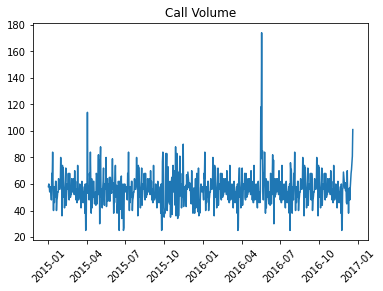

In [633]:
plt.plot(df)
plt.title('Call Volume')
plt.xticks(rotation=45)

In [634]:
decomp=seasonal_decompose(df['call_volume'], period=90)

Seasonality

<AxesSubplot:title={'center':'Seasonality'}, xlabel='call_date'>

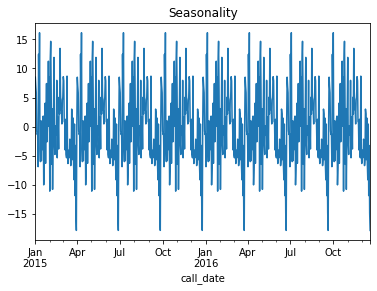

In [635]:
plt.title('Seasonality')
decomp.seasonal.plot()

Trend

<AxesSubplot:title={'center':'Trend'}, xlabel='call_date'>

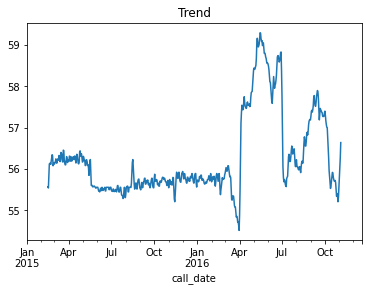

In [636]:
plt.title('Trend')
decomp.trend.plot()

Our trend plot proves that the dataset is stationary, i.e, it does not depend on time at which the series is observed

Residuals

<AxesSubplot:title={'center':'Residuals'}, xlabel='call_date'>

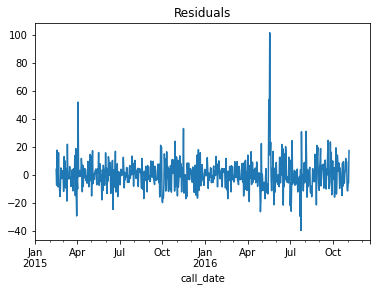

In [637]:
plt.title('Residuals')
decomp.resid.plot()

Autocorrelation function or ACF

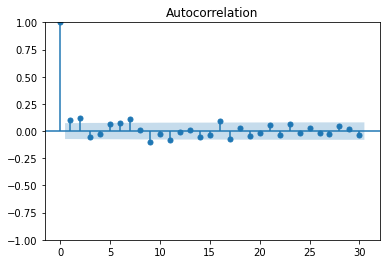

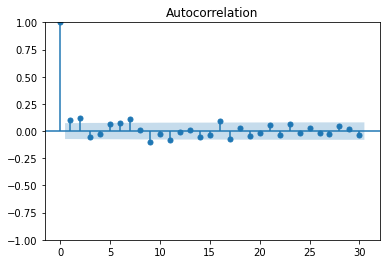

In [638]:
plot_acf(df, lags=30)

The ACF plot shows that there is one lag significantly correlated. 

Partial Autocorrelation function of PACF

c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


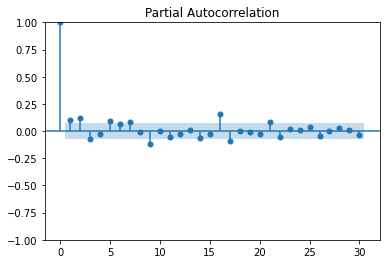

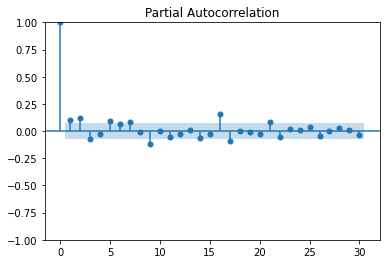

In [639]:
plot_pacf(df, lags=30)

Spectral density

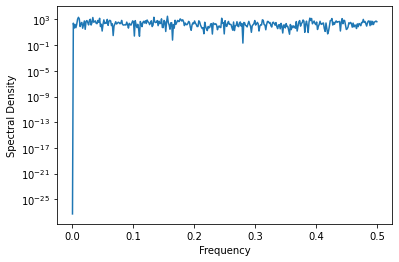

In [640]:
f, Pxx_den = signal.periodogram(df['call_volume'])
plt.semilogy(f, Pxx_den)
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

Decomponsed time series

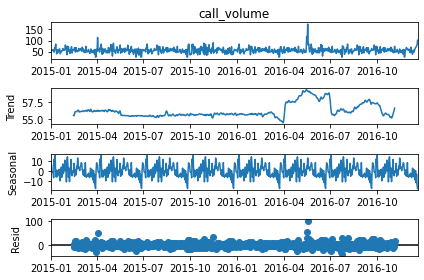

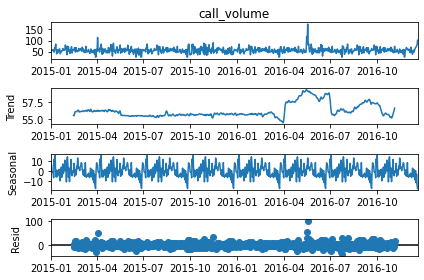

In [641]:
decomp.plot()

ARIMA model

We will run the ARMA model, i.e. Auto Regressive Moving Average model with the following values as our parameters:
-p=1
-q=1
-d=0

In [642]:
model = ARIMA(train, order=(1,0,1), seasonal_order=(1,0,1,90))
results = model.fit()
results.summary()

c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      call_volume   No. Observations:                  575
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 90)   Log Likelihood               -2254.072
Date:                          Tue, 27 Jun 2023   AIC                           4520.143
Time:                                  23:29:18   BIC                           4546.269
Sample:                              01-01-2015   HQIC                          4530.333
                                   - 07-28-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.3086      0.969     58.102      0.000      54.409      58.208
ar.L1          0.6443      0.302      2.132      0.033       0.052       1.237
ma.L1         -0.5865      0.322     -1.824      0.068      -1.217       0.044
ar.S.L90       0.5314      0.132      4.026      0.000       0.273       0.790
ma.S.L90      -0.2485      0.160     -1.552      0.121      -0.562       0.065
sigma2       146.1713      4.660     31.369      0.000     137.038     155.304
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              6328.60
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             1.99
Prob(H) (two-sided):                  0.03   Kurtosis:                        18.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [643]:
model2 = auto_arima(train, trace = True, error_action ='ignore', suppress_warnings = True)
model2.fit(train)
model2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4558.381, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4568.186, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4565.883, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4566.758, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6296.816, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4557.632, Time=0.57 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4556.501, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=4557.030, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4564.759, Time=0.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4558.673, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5486.964, Time=0.15 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 2.952 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  575
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -2274.250
Date:                Tue, 27 Jun 2023   AIC                           4556.501
Time:                        23:29:21   BIC                           4573.918
Sample:                    01-01-2015   HQIC                          4563.294
                         - 07-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     56.2389      0.727     77.390      0.000      54.815      57.663
ma.L1          0.0931      0.037      2.533      0.011       0.021       0.165
ma.L2          0.1573      0.029      5.418      0.000       0.100       0.214
sigma2       159.5668      6.321     25.245      0.000     147.178     171.955
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2236.74
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             1.40
Prob(H) (two-sided):                  0.10   Kurtosis:                        12.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [644]:
forecast= results.get_prediction(start=574, end=713, dynamic=True)
forecast_mean = forecast.predicted_mean

In [645]:
temp_forecast= pd.DataFrame(forecast_mean)
temp_forecast.rename(columns={'predicted_mean' : 'call_volume'}, inplace=True)
temp_forecast

,call_volume
2016-07-28,56.101549
2016-07-29,61.283448
2016-07-30,55.258011
2016-07-31,52.866109
2016-08-01,54.592033
...,...
2016-12-10,60.056791
2016-12-11,55.351484
2016-12-12,59.381692
2016-12-13,51.864124


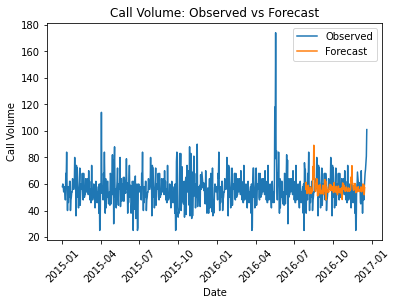

In [646]:
plt.plot(df.index, df, label='Observed')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.title('Call Volume: Observed vs Forecast')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.xticks(rotation=45)
plt.legend()
plt.show()

RMSE

In [650]:
rmse = mean_squared_error(temp_forecast, temp_forecast.iloc[-140:], squared=False)
print(f"The root mean squared error of this forecasting model is {round(rmse, 5)}")

The root mean squared error of this forecasting model is 0.0


Annotated Visualization

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31', '2023-02-01',
               '2023-02-02', '2023-02-03', '2023-02-04', '2023-02-05',
               '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
               '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13',
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17',
               '2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21',
               '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25',
      

<AxesSubplot:title={'center':'Daily Call Volume: Forecast 2023'}, xlabel='Date', ylabel='Call volume'>

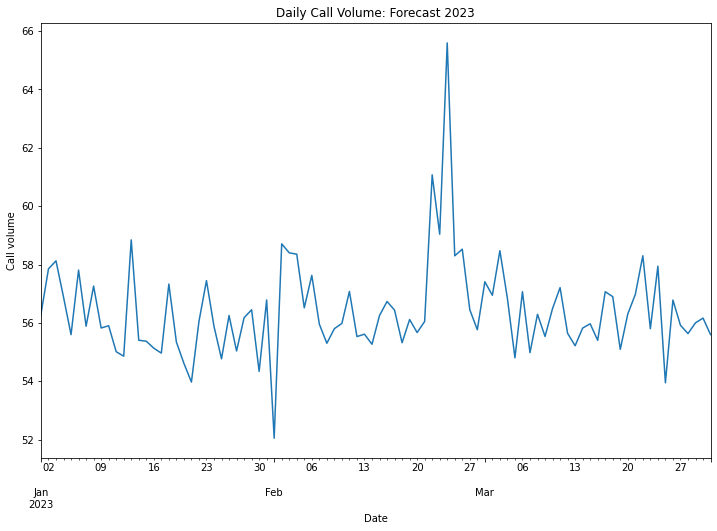

In [ ]:
index_future = pd.date_range(start='2023-01-01', end='2023-03-31')
print(index_future)
pred = results.predict(start=len(df), end=len(df)+89, type='levels')
pred.index=index_future
print(pred)

pred.plot(figsize=(12,8), xlabel='Date',ylabel='Call volume', title='Daily Call Volume: Forecast 2023')
